In [17]:
import arff, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV



In [18]:
columns = ['Project', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'PointsAjust', 'Envergure', 'PointsNonAdjust', 'Language']
df_desharnais = pd.read_csv('./desharnais.txt', names=columns, comment='%', skipinitialspace=True, delimiter=',')
df_desharnais.head()

print(df_desharnais['TeamExp'].unique())
print(df_desharnais['ManagerExp'].unique())

df_desharnais['TeamExp'] = df_desharnais['TeamExp'].replace('?', np.nan)
df_desharnais['TeamExp'] = pd.to_numeric(df_desharnais['TeamExp'], errors='coerce')
df_desharnais['TeamExp'].fillna(df_desharnais['TeamExp'].median(), inplace=True)

df_desharnais['ManagerExp'] = df_desharnais['ManagerExp'].replace('?', np.nan)
df_desharnais['ManagerExp'] = pd.to_numeric(df_desharnais['ManagerExp'], errors='coerce')
df_desharnais['ManagerExp'].fillna(df_desharnais['ManagerExp'].median(), inplace=True)



['1' '0' '4' '2' '3' '?']
['4' '0' '1' '2' '3' '?' '7' '5']


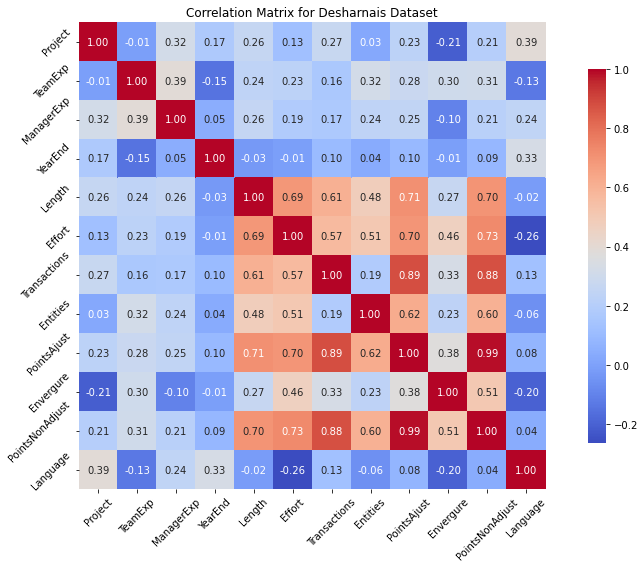

In [19]:
import seaborn as sns
correlation_matrix = df_desharnais.corr()

# Step 2: Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 3: Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Matrix for Desharnais Dataset')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjusts the plot to fit into the figure area.
plt.show()

In [20]:
max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']


# Define the attributes to keep
attributes_to_keep = [
    'Project',         # numeric
    'TeamExp',         # numeric (measured in years)
    'ManagerExp',      # numeric (measured in years)
    'Length',          # numeric
    'Effort',          # ActualEffort is measured in person-hours
    'Envergure',       # numeric
    'Language'        # categorical {1,2,3}
]

# Create a new DataFrame with only the specified attributes
filtered_df_desharnais = df_desharnais[attributes_to_keep]

# Display the new DataFrame
print(filtered_df_desharnais.head())


   Project  TeamExp  ManagerExp  Length  Effort  Envergure  Language
0        1      1.0         4.0      12    5152         34         1
1        2      0.0         0.0       4    5635         33         1
2        3      4.0         4.0       1     805         18         1
3        4      0.0         0.0       5    3829         30         1
4        5      0.0         0.0       4    2149         24         1


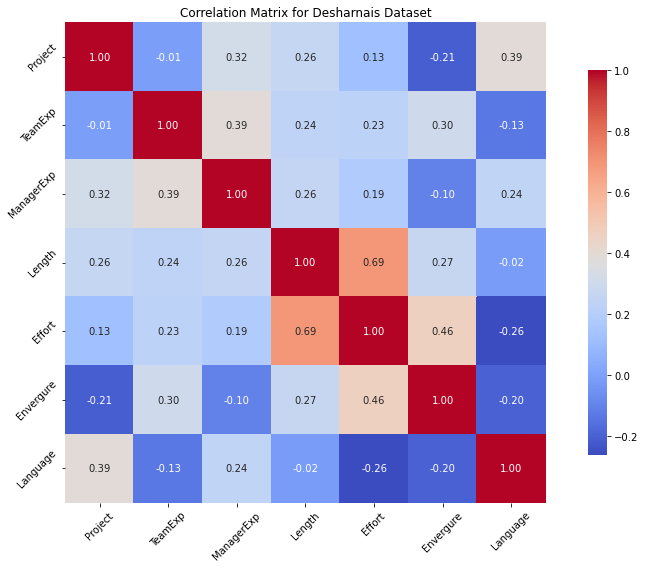

In [21]:
import seaborn as sns
correlation_matrix = filtered_df_desharnais.corr()

# Step 2: Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 3: Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Matrix for Desharnais Dataset')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjusts the plot to fit into the figure area.
plt.show()

In [22]:
features = df_desharnais.drop(columns=['Effort'])  # Input features
output = df_desharnais['Effort']                  

In [23]:
filtered_features = filtered_df_desharnais.drop(columns=['Effort'])  # Input features
filtered_output = filtered_df_desharnais['Effort']                  

In [24]:
print(features)

    Project  TeamExp  ManagerExp  YearEnd  Length  Transactions  Entities  \
0         1      1.0         4.0       85      12           253        52   
1         2      0.0         0.0       86       4           197       124   
2         3      4.0         4.0       85       1            40        60   
3         4      0.0         0.0       86       5           200       119   
4         5      0.0         0.0       86       4           140        94   
..      ...      ...         ...      ...     ...           ...       ...   
76       77      4.0         4.0       85      12           229       169   
77       78      4.0         3.0       83      12           227        73   
78       79      4.0         4.0       86      24           395       193   
79       80      4.0         3.0       86      12           469       176   
80       81      4.0         4.0       85      36           886       241   

    PointsAjust  Envergure  PointsNonAdjust  Language  
0           305    

In [25]:
print(output)

0      5152
1      5635
2       805
3      3829
4      2149
      ...  
76     1400
77     2800
78     9520
79     5880
80    23940
Name: Effort, Length: 81, dtype: int64


In [26]:
# Function to detect outliers using IQR for the entire dataframe
def detect_outliers_iqr(df):
    outliers_dict = {}
    for column in df.select_dtypes(include=[np.number]).columns:  # Only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Store outliers for each column
        if not outliers.empty:
            outliers_dict[column] = outliers
    return outliers_dict

# Detecting outliers for all numeric columns
outliers_dict = detect_outliers_iqr(features)

# Display outliers for each column
for column, outliers in outliers_dict.items():
    print(f"Outliers in '{column}':")
    print(outliers[['Project', column]])  # Display only the project and the outlier column
    print("\n")

Outliers in 'Length':
    Project  Length
41       42      34
43       44      39
45       46      27
80       81      36


Outliers in 'Transactions':
    Project  Transactions
40       41           451
41       42           661
72       73           482
75       76           473
79       80           469
80       81           886


Outliers in 'Entities':
    Project  Entities
18       19       386
55       56       387


Outliers in 'PointsAjust':
    Project  PointsAjust
41       42          793
72       73          709
80       81         1127


Outliers in 'PointsNonAdjust':
    Project  PointsNonAdjust
41       42              698
75       76              688
79       80              697
80       81             1116




In [27]:
def count_outliers(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

outlier_counts = count_outliers(features)

# Creating a table from the outlier counts
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])

# Displaying the table
print(outlier_counts_df)


            Feature  Outlier Count
0           Project              0
1           TeamExp              0
2        ManagerExp              0
3           YearEnd              0
4            Length              4
5      Transactions              6
6          Entities              2
7       PointsAjust              3
8         Envergure              0
9   PointsNonAdjust              4
10         Language              0


In [28]:
def count_outliers(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

outlier_counts = count_outliers(filtered_features)

# Creating a table from the outlier counts
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])

# Displaying the table
print(outlier_counts_df)


      Feature  Outlier Count
0     Project              0
1     TeamExp              0
2  ManagerExp              0
3      Length              4
4   Envergure              0
5    Language              0


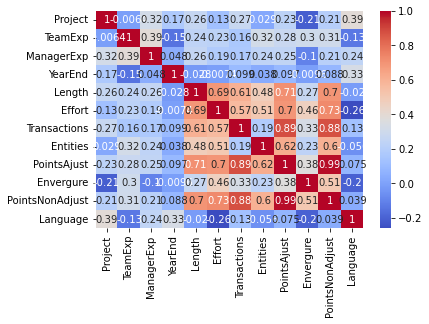

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df_desharnais.corr()

# Heatmap to visualize correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [30]:
#Picked the entitites with more than 0.5 correraltion, however this shows teamexp and manager exp is less correlated
#according to my domain knowledge team exp and manager expereine also matters
features = [ 'TeamExp', 'ManagerExp', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust',  'PointsAjust']

max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

X = df_desharnais[features]
Y = df_desharnais['Effort']

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from pyearth import Earth

# Assuming filtered_features and filtered_output are your datasets
X = filtered_features
y = filtered_output

# Define hyperparameter grids for each individual model
param_grids = {
    'Linear Regression': {},
    'SVR': {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 10],
        'epsilon': [0.001, 0.01, 0.1],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [5, 10]
    },
    'Stacked Ensemble': {
        'meta_learner__fit_intercept': [True, False]
    },
    'Earth': {
        'max_terms': [50, 100],
        'penalty': [2, 3, 4],
        'smooth': [0.1, 0.2, 0.3],
        'minspan': [2, 5]
    }
}

# PCR Model with PCA and Linear Regression
pcr_model = make_pipeline(PCA(n_components=0.95), LinearRegression())

# Define base learners for Stacked Ensemble, with PCR, MARS (Earth), and other models
base_learners = [
    ('PCR', pcr_model),  # Add PCR at the start
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Neural Net', MLPRegressor(max_iter=1000)),
    ('Elastic Net', ElasticNet()),
    ('XGBoost', xgb.XGBRegressor()),
    ('Earth', Earth())  # Add Earth (MARS) after XGBoost
]

# Function to evaluate models
def evaluate_model(y_test, y_pred, computation_time):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    pred_25 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.25) * 100
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    explained_variance = explained_variance_score(y_test, y_pred)
    max_error = np.max(np.abs(y_test - y_pred))
    median_ae = np.median(np.abs(y_test - y_pred))
    return {
        'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R-Squared': r2,
        'PRED(25)': pred_25, 'MAPE': mape, 'Explained Variance': explained_variance,
        'Max Error': max_error, 'Median AE': median_ae,
        'Computation Time (s)': computation_time
    }

# Results storage
results = []

# Loop over train-test splits
for train_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=42)

    # Linear Regression
    start_time = time.time()
    lr = LinearRegression().fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    results.append({
        'Model': 'Linear Regression',
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        **evaluate_model(y_test, y_pred, time.time() - start_time)
    })

    # Support Vector Regressor with GridSearchCV
    start_time = time.time()
    svr = GridSearchCV(SVR(), param_grids['SVR'], scoring='r2', cv=3, n_jobs=-1).fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    results.append({
        'Model': 'SVR',
        'Best Params': svr.best_params_,
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        **evaluate_model(y_test, y_pred, time.time() - start_time)
    })

    # Gradient Boosting with GridSearchCV
    start_time = time.time()
    gbr = GridSearchCV(GradientBoostingRegressor(), param_grids['Gradient Boosting'], scoring='r2', cv=3, n_jobs=-1).fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    results.append({
        'Model': 'Gradient Boosting',
        'Best Params': gbr.best_params_,
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        **evaluate_model(y_test, y_pred, time.time() - start_time)
    })

    # Stacked Ensemble
    start_time = time.time()
    base_train_preds, base_test_preds = [], []
    for name, model in base_learners:
        model.fit(X_train, y_train)
        base_train_preds.append(model.predict(X_train))
        base_test_preds.append(model.predict(X_test))
    meta_X_train = np.column_stack(base_train_preds)
    meta_X_test = np.column_stack(base_test_preds)
    meta_learner = LinearRegression().fit(meta_X_train, y_train)
    final_predictions = meta_learner.predict(meta_X_test)
    results.append({
        'Model': 'Stacked Ensemble',
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        **evaluate_model(y_test, final_predictions, time.time() - start_time)
    })

    # PCR + MARS Hybrid Model
    start_time = time.time()

    # PCR model
    pcr_model.fit(X_train, y_train)
    y_pred_pcr = pcr_model.predict(X_test)

    # Earth (MARS) model
    earth_model = Earth()
    earth_model.fit(X_train, y_train)
    y_pred_mars = earth_model.predict(X_test)

    # Combine PCR + MARS predictions
    w = 0.9  # Weight for PCR (adjust as needed)
    final_y_pred_hybrid = w * y_pred_pcr + (1 - w) * y_pred_mars

    results.append({
        'Model': 'PCR + MARS Hybrid',
        'Train Size (%)': f"{int(train_size * 100)}%",
        'Test Size (%)': f"{int((1 - train_size) * 100)}%",
        **evaluate_model(y_test, final_y_pred_hybrid, time.time() - start_time)
    })

# Save results to DataFrame and Excel file
results_df = pd.DataFrame(results)
results_df.to_excel('effort_estimation_results_desharnais.xlsx', index=False)
print(results_df)


c:\Anaconda3\envs\mars\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\Anaconda3\envs\mars\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
c:\Anaconda3\envs\mars\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B

                Model Train Size (%) Test Size (%)          MAE           MSE  \
0   Linear Regression            50%           50%  2241.391742  9.044121e+06   
1                 SVR            50%           50%  2322.814622  1.544641e+07   
2   Gradient Boosting            50%           50%  2576.772798  1.542430e+07   
3    Stacked Ensemble            50%           50%  3776.414634  3.208232e+07   
4   PCR + MARS Hybrid            50%           50%  2222.264811  9.716884e+06   
5   Linear Regression            60%           40%  2243.611470  9.787507e+06   
6                 SVR            60%           40%  2205.091072  1.216114e+07   
7   Gradient Boosting            60%           40%  2586.839276  1.759228e+07   
8    Stacked Ensemble            60%           40%  3635.333333  2.740041e+07   
9   PCR + MARS Hybrid            60%           40%  2228.023294  1.066029e+07   
10  Linear Regression            70%           30%  1559.117610  4.220292e+06   
11                SVR       